In [1]:
import os
os.environ['HF_HOME'] = '/workspace/cache/huggingface/'
os.chdir('/workspace/FutureGPT2/src/')

import datasets
from torch.utils.data import DataLoader
from torch import nn
from itertools import islice
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
from datasets import Dataset, load_dataset
from torch import nn
from models.myopic_model import *

from tqdm import tqdm
import pandas as pd
import gc
from glob import glob
import numpy as np
import copy
from collections import defaultdict
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
config = AutoConfig.from_pretrained("EleutherAI/pythia-70m-deduped")
config.upcast_attn = True
model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/pythia-70m-deduped",
    config=config,
    revision="step3000",
)

In [38]:
train = load_dataset(
    'EleutherAI/pile-deduped-pythia-random-sampled', 
    split='train[-1000:]'
)
train = train.rename_column('Tokens', 'input_ids')
train = train.remove_columns([c for c in train.column_names if c != 'input_ids'])
train = train.cast_column('input_ids', datasets.Sequence(datasets.Value('int64')))
train = train.with_format('torch')
train_loader = DataLoader(train, batch_size=64, drop_last=True)#, num_workers=96)

In [43]:
total_norms = []
myopic_norms = []
future_norms = []
corrs = []
losses = []
steps = [0] + [2**x for x in range(10)] + list(range(1_000, 70_000, 1000))
for step in tqdm(steps):
    gc.collect(); torch.cuda.empty_cache()
    myopic_grad = defaultdict(lambda: 0)
    future_grad = defaultdict(lambda: 0)
    total_grad = defaultdict(lambda: 0)
    model = AutoModelForCausalLM.from_pretrained(
        "EleutherAI/pythia-410m-deduped",
        revision=f"step{step}",
    ).to('cuda')
    #with torch.autocast(enabled=True, device_type='cuda', dtype=torch.float16):
    # with torch.autocast(enabled=False, device_type='cuda'):
    #total
    loss = 0
    for i, batch in enumerate(train_loader):
        batch['input_ids'] = batch['input_ids'].to('cuda')
        batch['labels'] = batch['input_ids']
        cur_loss = model(**batch).loss
        cur_loss.backward()
        for name, param in model.named_parameters():
            if 'embed' not in name:
                total_grad[name] += param.grad
        model.zero_grad()
        loss += cur_loss
    loss /= len(train_loader)
    # myopic
    model = to_myopic_neox(model, [None for _ in range(len(model.gpt_neox.layers))], reverse=False)
    for i, batch in enumerate(train_loader):
        batch['input_ids'] = batch['input_ids'].to('cuda')
        batch['labels'] = batch['input_ids']
        cur_loss = model(**batch).loss
        cur_loss.backward()
        for name, param in model.named_parameters():
            if 'embed' not in name:
                myopic_grad[name] += param.grad
        model.zero_grad()
    # future
    future_grad = {k: total_grad[k] - myopic_grad[k] for k in total_grad}
        
    myopic_norm = sum(v.norm()**2 for v in myopic_grad.values())**0.5
    future_norm = sum(v.norm()**2 for v in future_grad.values())**0.5
    total_norm = sum(v.norm()**2 for v in total_grad.values())**0.5
    corr = sum((u*v).sum() for u, v in zip(myopic_grad.values(), future_grad.values())) / myopic_norm / future_norm
    myopic_norms.append(myopic_norm.item())
    future_norms.append(future_norm.item())
    total_norms.append(total_norm.item())
    corrs.append(corr)
    losses.append(loss.item())

  5%|▌         | 4/80 [01:25<27:12, 21.48s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

  6%|▋         | 5/80 [02:01<33:04, 26.46s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

  8%|▊         | 6/80 [02:36<36:28, 29.57s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

  9%|▉         | 7/80 [03:22<42:31, 34.96s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 10%|█         | 8/80 [04:09<46:32, 38.79s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 11%|█▏        | 9/80 [04:59<50:02, 42.29s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 12%|█▎        | 10/80 [05:42<49:16, 42.24s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 14%|█▍        | 11/80 [06:31<51:12, 44.53s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 15%|█▌        | 12/80 [07:06<47:09, 41.61s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 16%|█▋        | 13/80 [07:58<49:48, 44.61s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 18%|█▊        | 14/80 [08:26<43:41, 39.73s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 19%|█▉        | 15/80 [09:21<47:49, 44.15s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 20%|██        | 16/80 [10:07<47:42, 44.72s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 21%|██▏       | 17/80 [10:44<44:31, 42.41s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 22%|██▎       | 18/80 [11:25<43:31, 42.12s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 24%|██▍       | 19/80 [12:07<42:48, 42.10s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 25%|██▌       | 20/80 [12:56<44:12, 44.20s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 26%|██▋       | 21/80 [13:45<44:50, 45.60s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 28%|██▊       | 22/80 [14:27<42:52, 44.35s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 29%|██▉       | 23/80 [15:18<44:14, 46.58s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 30%|███       | 24/80 [16:03<43:04, 46.15s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 31%|███▏      | 25/80 [16:47<41:42, 45.49s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 32%|███▎      | 26/80 [17:31<40:31, 45.02s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 34%|███▍      | 27/80 [18:09<37:55, 42.93s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 35%|███▌      | 28/80 [18:45<35:23, 40.84s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 36%|███▋      | 29/80 [19:27<35:02, 41.22s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 38%|███▊      | 30/80 [20:17<36:32, 43.85s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 39%|███▉      | 31/80 [20:54<34:01, 41.67s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 40%|████      | 32/80 [21:38<33:59, 42.48s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 41%|████▏     | 33/80 [22:28<35:03, 44.76s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 42%|████▎     | 34/80 [23:14<34:24, 44.88s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 44%|████▍     | 35/80 [23:50<31:46, 42.37s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 45%|████▌     | 36/80 [24:34<31:19, 42.72s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 46%|████▋     | 37/80 [25:17<30:45, 42.91s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 48%|████▊     | 38/80 [26:08<31:37, 45.19s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 49%|████▉     | 39/80 [26:57<31:47, 46.53s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 50%|█████     | 40/80 [27:42<30:37, 45.93s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 51%|█████▏    | 41/80 [28:28<29:55, 46.04s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 52%|█████▎    | 42/80 [29:15<29:22, 46.39s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 54%|█████▍    | 43/80 [29:52<26:44, 43.37s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 55%|█████▌    | 44/80 [30:27<24:30, 40.86s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 56%|█████▋    | 45/80 [31:02<22:54, 39.28s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 57%|█████▊    | 46/80 [31:53<24:12, 42.72s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 59%|█████▉    | 47/80 [32:35<23:23, 42.54s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 60%|██████    | 48/80 [33:12<21:48, 40.88s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 61%|██████▏   | 49/80 [33:55<21:29, 41.60s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 62%|██████▎   | 50/80 [34:31<19:54, 39.82s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 64%|██████▍   | 51/80 [35:15<19:49, 41.03s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 65%|██████▌   | 52/80 [36:06<20:30, 43.95s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 66%|██████▋   | 53/80 [36:49<19:38, 43.64s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 68%|██████▊   | 54/80 [37:22<17:32, 40.48s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 69%|██████▉   | 55/80 [38:05<17:10, 41.22s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 70%|███████   | 56/80 [38:44<16:19, 40.80s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 71%|███████▏  | 57/80 [39:27<15:53, 41.46s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 72%|███████▎  | 58/80 [40:02<14:27, 39.45s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 74%|███████▍  | 59/80 [40:44<14:00, 40.04s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 75%|███████▌  | 60/80 [41:18<12:45, 38.26s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 76%|███████▋  | 61/80 [42:02<12:43, 40.20s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 78%|███████▊  | 62/80 [42:46<12:20, 41.16s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 79%|███████▉  | 63/80 [43:29<11:47, 41.63s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 80%|████████  | 64/80 [44:20<11:52, 44.51s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 81%|████████▏ | 65/80 [44:59<10:42, 42.81s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 82%|████████▎ | 66/80 [45:45<10:13, 43.81s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 84%|████████▍ | 67/80 [46:33<09:45, 45.07s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 85%|████████▌ | 68/80 [47:10<08:33, 42.76s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 86%|████████▋ | 69/80 [47:44<07:20, 40.02s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 88%|████████▊ | 70/80 [48:31<07:00, 42.05s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 89%|████████▉ | 71/80 [49:07<06:03, 40.35s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 90%|█████████ | 72/80 [49:43<05:13, 39.18s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 91%|█████████▏| 73/80 [50:21<04:31, 38.73s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 92%|█████████▎| 74/80 [50:57<03:47, 37.91s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 94%|█████████▍| 75/80 [51:42<03:20, 40.08s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 95%|█████████▌| 76/80 [52:32<02:51, 42.99s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 96%|█████████▋| 77/80 [53:22<02:14, 44.96s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 98%|█████████▊| 78/80 [54:13<01:33, 46.90s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

 99%|█████████▉| 79/80 [54:56<00:45, 45.82s/it]

pytorch_model.bin:   0%|          | 0.00/911M [00:00<?, ?B/s]

100%|██████████| 80/80 [55:34<00:00, 41.68s/it]


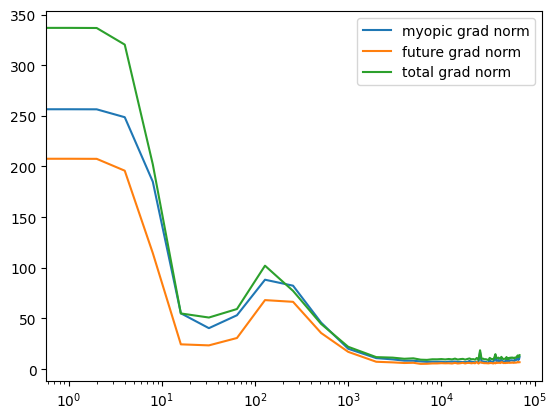

In [44]:
plt.plot(steps, myopic_norms, label='myopic grad norm')
plt.plot(steps, future_norms, label='future grad norm')
plt.plot(steps, total_norms, label='total grad norm')
plt.xscale('log')
plt.legend()
plt.show()

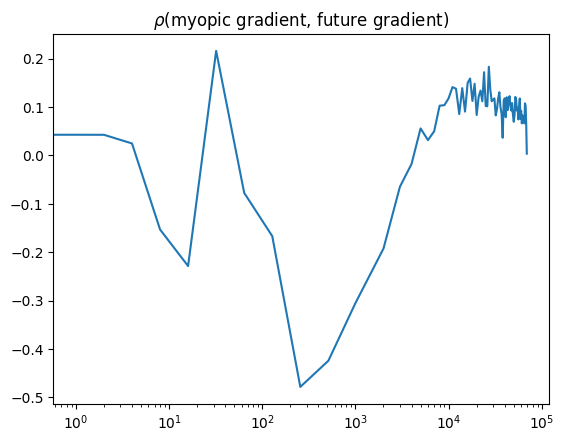

In [45]:
plt.plot(steps, [c.item() for c in corrs])
plt.title('$\\rho$(myopic gradient, future gradient)')
plt.xscale('log')
plt.show()

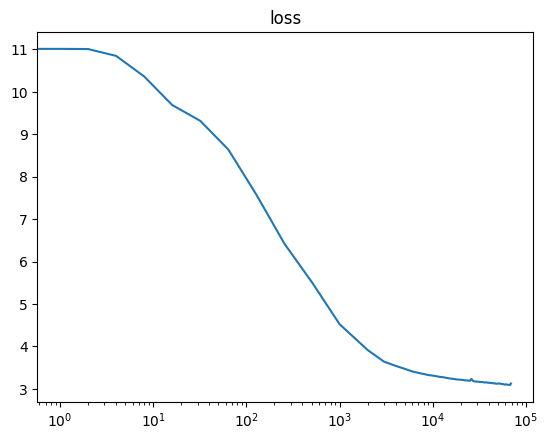

In [47]:
plt.plot(steps, losses)
plt.title('loss')
plt.xscale('log')
plt.show()

In [7]:
model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/pythia-70m-deduped",
    revision=f"step10000",
)

In [10]:
batch = next(iter(train_loader))
batch['labels'] = batch['input_ids']

In [12]:
out = model(**batch)
out.loss.backward()
grad = dict()
for name, param in model.named_parameters():
    grad[name] = param.grad
model.zero_grad()

In [13]:
myopic_grad = dict()
model = to_myopic_neox(model, [None for _ in range(len(model.gpt_neox.layers))], reverse=False)
myopic_out = model(**batch)
myopic_out.loss.backward()
for name, param in model.named_parameters():
    myopic_grad[name] = param.grad
model.zero_grad()

In [14]:
future_grad = dict()
model = to_myopic_neox(model, [None for _ in range(len(model.gpt_neox.layers))], reverse=True)
future_out = model(**batch)
future_out.loss.backward()
for name, param in model.named_parameters():
    future_grad[name] = param.grad
model.zero_grad()

In [18]:
for name in future_grad:
    print(name, ((grad[name] - future_grad[name] - myopic_grad[name]).norm() / grad[name].norm()).item())
    print(grad[name].norm().item())

gpt_neox.embed_in.weight 0.5712848901748657
0.9477283358573914
gpt_neox.layers.0.input_layernorm.weight 0.6179928183555603
0.03921118006110191
gpt_neox.layers.0.input_layernorm.bias 0.6231682300567627
0.07896964997053146
gpt_neox.layers.0.post_attention_layernorm.weight 0.4307343661785126
0.05105995014309883
gpt_neox.layers.0.post_attention_layernorm.bias 0.5273765325546265
0.06771998107433319
gpt_neox.layers.0.attention.query_key_value.weight 0.44463539123535156
0.9856925010681152
gpt_neox.layers.0.attention.query_key_value.bias 0.45407405495643616
0.0833536684513092
gpt_neox.layers.0.attention.dense.weight 0.4979739785194397
0.7238209247589111
gpt_neox.layers.0.attention.dense.bias 0.5198664665222168
0.11288242042064667
gpt_neox.layers.0.mlp.dense_h_to_4h.weight 0.4395763576030731
0.5749503970146179
gpt_neox.layers.0.mlp.dense_h_to_4h.bias 0.5069559812545776
0.04991208389401436
gpt_neox.layers.0.mlp.dense_4h_to_h.weight 0.4476035237312317
0.8676067590713501
gpt_neox.layers.0.mlp.dens